# Convolutional Neural Network (CNN)
- recognize the digit using pixel value
- use PyTorch

## Import the libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
# from tqdm.notebook import trange, tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# use cuda to accelerate the computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import datasets

In [3]:
df_train = pd.DataFrame(pd.read_csv('train.csv'))
df_test = pd.DataFrame(pd.read_csv('test.csv'))

In [4]:
df_train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Understand and visualize the dataset

### The unique digit in the dataset

In [5]:
unique_values = df_train['label'].unique()
unique_values.sort()
print(unique_values)

[0 1 2 3 4 5 6 7 8 9]


### The distribution of the label in the dataset
- the distribution is roughly uniform

<AxesSubplot:ylabel='Frequency'>

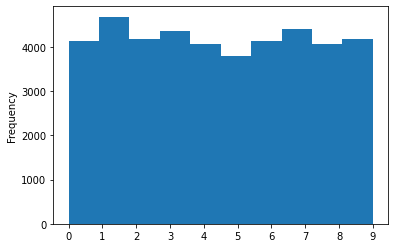

In [6]:
df_train['label'].plot.hist(bins=10, xticks=unique_values)

In [7]:
df_train.value_counts('label')

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
dtype: int64

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
y = df_train['label']
X = df_train.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Use MinMaxScaler to normalize data
- the digit label doesn't need to be normalized since it's the target class
- normalize the pixel values

In [10]:
scaler = MinMaxScaler()
# reference: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
# the fit_transform method always used on training data
# the purpose is to calculate the mean and variance of each of the features
X_train = scaler.fit_transform(X_train)
# the transform method uses the calculated mean and variance
# to transform the test data

# the label doesn't need to be normalized -> it's the digit class
X_test = scaler.fit_transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((33600, 784), (8400, 784), (33600,), (8400,))

## Following the tutorial
reference: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [12]:
class ClassifierDataset(Dataset):
  def __init__(self, X_data, y_data):
    super(ClassifierDataset, self).__init__()
    self.X_data = X_data
    self.y_data = y_data
      
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
      
  def __len__ (self):
    return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Define and optimize the model
- specify the parameters
- specify optimization model and learning rate
- see whether more layers or nodes per layer improve the performance
  - reference: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [71]:
# TODO: tune the parameters
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns) # the optimal size of the hidden layer is between the features and the classes
NUM_CLASSES = 10

In [72]:
# training loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader

In [73]:
# validation loader
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

### Simple 3-layer feed-forward network
- with drop and batch-norm

In [74]:
class MulticlassClassification(nn.Module):
    """ The simple three layer multi-classification class
    
    """
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.layer_out(x)
        
        return x

In [75]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Specify the optimizer

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### The model description

In [77]:
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training the model

In [78]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
  
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  
  acc = torch.round(acc * 100)
  
  return acc

In [79]:
accuracy_stats = {
  'train': [],
  "val": []
}
loss_stats = {
  'train': [],
  "val": []
}

In [80]:
# reference: https://stackoverflow.com/questions/54374935/how-to-fix-this-strange-error-runtimeerror-cuda-error-out-of-memory
import gc
gc.collect()

torch.cuda.empty_cache()

### Training process

In [81]:
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  1%|          | 1/100 [00:46<1:16:28, 46.35s/it]

Epoch 001: | Train Loss: 0.54230 | Val Loss: 0.17936 | Train Acc: 84.606| Val Acc: 94.643


  2%|▏         | 2/100 [01:21<1:04:37, 39.57s/it]

Epoch 002: | Train Loss: 0.32471 | Val Loss: 0.13984 | Train Acc: 90.417| Val Acc: 95.786


  3%|▎         | 3/100 [01:55<59:52, 37.04s/it]  

Epoch 003: | Train Loss: 0.27112 | Val Loss: 0.11316 | Train Acc: 91.840| Val Acc: 96.524


  4%|▍         | 4/100 [02:29<57:37, 36.01s/it]

Epoch 004: | Train Loss: 0.23861 | Val Loss: 0.09992 | Train Acc: 92.802| Val Acc: 96.952


  5%|▌         | 5/100 [03:02<55:19, 34.95s/it]

Epoch 005: | Train Loss: 0.22476 | Val Loss: 0.09631 | Train Acc: 93.323| Val Acc: 96.845


  6%|▌         | 6/100 [03:35<53:49, 34.36s/it]

Epoch 006: | Train Loss: 0.20990 | Val Loss: 0.09273 | Train Acc: 93.665| Val Acc: 97.167


  7%|▋         | 7/100 [04:08<52:30, 33.88s/it]

Epoch 007: | Train Loss: 0.18880 | Val Loss: 0.08572 | Train Acc: 94.321| Val Acc: 97.333


  8%|▊         | 8/100 [04:42<51:44, 33.74s/it]

Epoch 008: | Train Loss: 0.18348 | Val Loss: 0.08251 | Train Acc: 94.641| Val Acc: 97.476


  9%|▉         | 9/100 [05:15<50:49, 33.51s/it]

Epoch 009: | Train Loss: 0.17433 | Val Loss: 0.07807 | Train Acc: 94.797| Val Acc: 97.440


 10%|█         | 10/100 [05:49<50:43, 33.82s/it]

Epoch 010: | Train Loss: 0.16459 | Val Loss: 0.07975 | Train Acc: 95.097| Val Acc: 97.488


 11%|█         | 11/100 [06:24<50:27, 34.02s/it]

Epoch 011: | Train Loss: 0.15950 | Val Loss: 0.07746 | Train Acc: 95.148| Val Acc: 97.536


 12%|█▏        | 12/100 [06:57<49:34, 33.81s/it]

Epoch 012: | Train Loss: 0.15226 | Val Loss: 0.07315 | Train Acc: 95.405| Val Acc: 97.762


 13%|█▎        | 13/100 [07:30<48:47, 33.64s/it]

Epoch 013: | Train Loss: 0.14999 | Val Loss: 0.07110 | Train Acc: 95.539| Val Acc: 97.833


 14%|█▍        | 14/100 [08:03<47:43, 33.29s/it]

Epoch 014: | Train Loss: 0.13727 | Val Loss: 0.06801 | Train Acc: 95.749| Val Acc: 97.940


 15%|█▌        | 15/100 [08:36<46:55, 33.13s/it]

Epoch 015: | Train Loss: 0.13961 | Val Loss: 0.07028 | Train Acc: 95.717| Val Acc: 97.893


 16%|█▌        | 16/100 [09:10<46:54, 33.51s/it]

Epoch 016: | Train Loss: 0.12821 | Val Loss: 0.06124 | Train Acc: 96.087| Val Acc: 98.143


 17%|█▋        | 17/100 [09:43<46:18, 33.47s/it]

Epoch 017: | Train Loss: 0.12386 | Val Loss: 0.07046 | Train Acc: 96.350| Val Acc: 97.821


 18%|█▊        | 18/100 [10:16<45:22, 33.21s/it]

Epoch 018: | Train Loss: 0.12422 | Val Loss: 0.06478 | Train Acc: 96.176| Val Acc: 98.048


 19%|█▉        | 19/100 [10:49<44:48, 33.20s/it]

Epoch 019: | Train Loss: 0.12485 | Val Loss: 0.06246 | Train Acc: 96.230| Val Acc: 98.060


 20%|██        | 20/100 [11:22<44:08, 33.10s/it]

Epoch 020: | Train Loss: 0.12070 | Val Loss: 0.06062 | Train Acc: 96.263| Val Acc: 98.131


 21%|██        | 21/100 [11:56<44:02, 33.44s/it]

Epoch 021: | Train Loss: 0.11583 | Val Loss: 0.06318 | Train Acc: 96.543| Val Acc: 98.071


 22%|██▏       | 22/100 [12:29<43:01, 33.10s/it]

Epoch 022: | Train Loss: 0.11499 | Val Loss: 0.06265 | Train Acc: 96.464| Val Acc: 98.036


 23%|██▎       | 23/100 [13:01<42:03, 32.77s/it]

Epoch 023: | Train Loss: 0.10849 | Val Loss: 0.05675 | Train Acc: 96.663| Val Acc: 98.202


 24%|██▍       | 24/100 [13:33<41:14, 32.55s/it]

Epoch 024: | Train Loss: 0.10996 | Val Loss: 0.05851 | Train Acc: 96.550| Val Acc: 98.107


 25%|██▌       | 25/100 [14:05<40:33, 32.45s/it]

Epoch 025: | Train Loss: 0.10811 | Val Loss: 0.05780 | Train Acc: 96.678| Val Acc: 98.250


 26%|██▌       | 26/100 [14:40<41:06, 33.33s/it]

Epoch 026: | Train Loss: 0.10530 | Val Loss: 0.06168 | Train Acc: 96.759| Val Acc: 98.024


 27%|██▋       | 27/100 [15:17<41:55, 34.46s/it]

Epoch 027: | Train Loss: 0.09990 | Val Loss: 0.06085 | Train Acc: 96.855| Val Acc: 97.976


 28%|██▊       | 28/100 [15:52<41:20, 34.46s/it]

Epoch 028: | Train Loss: 0.10402 | Val Loss: 0.05952 | Train Acc: 96.797| Val Acc: 98.036


 29%|██▉       | 29/100 [16:25<40:11, 33.97s/it]

Epoch 029: | Train Loss: 0.10555 | Val Loss: 0.06365 | Train Acc: 96.792| Val Acc: 98.083


 30%|███       | 30/100 [16:57<39:05, 33.51s/it]

Epoch 030: | Train Loss: 0.09973 | Val Loss: 0.05673 | Train Acc: 96.861| Val Acc: 98.167


 31%|███       | 31/100 [17:29<38:09, 33.18s/it]

Epoch 031: | Train Loss: 0.09302 | Val Loss: 0.06059 | Train Acc: 97.059| Val Acc: 98.167


 32%|███▏      | 32/100 [18:03<37:53, 33.43s/it]

Epoch 032: | Train Loss: 0.09873 | Val Loss: 0.05947 | Train Acc: 96.943| Val Acc: 98.012


 33%|███▎      | 33/100 [18:37<37:14, 33.35s/it]

Epoch 033: | Train Loss: 0.09187 | Val Loss: 0.06204 | Train Acc: 97.238| Val Acc: 98.119


 34%|███▍      | 34/100 [19:09<36:22, 33.07s/it]

Epoch 034: | Train Loss: 0.09230 | Val Loss: 0.05960 | Train Acc: 97.079| Val Acc: 98.214


 35%|███▌      | 35/100 [19:42<35:39, 32.92s/it]

Epoch 035: | Train Loss: 0.08807 | Val Loss: 0.05980 | Train Acc: 97.266| Val Acc: 98.131


 36%|███▌      | 36/100 [20:14<34:53, 32.71s/it]

Epoch 036: | Train Loss: 0.08931 | Val Loss: 0.05632 | Train Acc: 97.243| Val Acc: 98.226


 37%|███▋      | 37/100 [20:47<34:38, 32.99s/it]

Epoch 037: | Train Loss: 0.08500 | Val Loss: 0.05926 | Train Acc: 97.412| Val Acc: 98.119


 38%|███▊      | 38/100 [21:19<33:48, 32.71s/it]

Epoch 038: | Train Loss: 0.08736 | Val Loss: 0.05938 | Train Acc: 97.366| Val Acc: 98.286


 39%|███▉      | 39/100 [21:52<33:13, 32.68s/it]

Epoch 039: | Train Loss: 0.09148 | Val Loss: 0.05692 | Train Acc: 97.259| Val Acc: 98.155


 40%|████      | 40/100 [22:26<33:01, 33.02s/it]

Epoch 040: | Train Loss: 0.08218 | Val Loss: 0.05568 | Train Acc: 97.523| Val Acc: 98.310


 41%|████      | 41/100 [22:58<32:11, 32.74s/it]

Epoch 041: | Train Loss: 0.08603 | Val Loss: 0.05705 | Train Acc: 97.423| Val Acc: 98.131


 42%|████▏     | 42/100 [23:30<31:28, 32.56s/it]

Epoch 042: | Train Loss: 0.08076 | Val Loss: 0.05376 | Train Acc: 97.375| Val Acc: 98.345


 43%|████▎     | 43/100 [24:03<30:52, 32.50s/it]

Epoch 043: | Train Loss: 0.08559 | Val Loss: 0.05999 | Train Acc: 97.346| Val Acc: 98.155


 44%|████▍     | 44/100 [24:35<30:12, 32.37s/it]

Epoch 044: | Train Loss: 0.08138 | Val Loss: 0.06494 | Train Acc: 97.544| Val Acc: 97.964


 45%|████▌     | 45/100 [25:08<30:04, 32.81s/it]

Epoch 045: | Train Loss: 0.08033 | Val Loss: 0.05938 | Train Acc: 97.535| Val Acc: 98.202


 46%|████▌     | 46/100 [25:42<29:39, 32.96s/it]

Epoch 046: | Train Loss: 0.08077 | Val Loss: 0.05882 | Train Acc: 97.480| Val Acc: 98.107


 47%|████▋     | 47/100 [26:14<29:00, 32.83s/it]

Epoch 047: | Train Loss: 0.08510 | Val Loss: 0.05757 | Train Acc: 97.383| Val Acc: 98.238


 48%|████▊     | 48/100 [26:47<28:33, 32.94s/it]

Epoch 048: | Train Loss: 0.07670 | Val Loss: 0.05654 | Train Acc: 97.605| Val Acc: 98.321


 49%|████▉     | 49/100 [27:20<27:51, 32.77s/it]

Epoch 049: | Train Loss: 0.08095 | Val Loss: 0.05828 | Train Acc: 97.587| Val Acc: 98.167


 50%|█████     | 50/100 [27:53<27:18, 32.77s/it]

Epoch 050: | Train Loss: 0.07919 | Val Loss: 0.05687 | Train Acc: 97.562| Val Acc: 98.321


 51%|█████     | 51/100 [28:26<26:50, 32.87s/it]

Epoch 051: | Train Loss: 0.07628 | Val Loss: 0.05781 | Train Acc: 97.627| Val Acc: 98.190


 52%|█████▏    | 52/100 [28:58<26:16, 32.85s/it]

Epoch 052: | Train Loss: 0.07485 | Val Loss: 0.05612 | Train Acc: 97.734| Val Acc: 98.345


 53%|█████▎    | 53/100 [29:31<25:40, 32.78s/it]

Epoch 053: | Train Loss: 0.07703 | Val Loss: 0.05700 | Train Acc: 97.567| Val Acc: 98.393


 54%|█████▍    | 54/100 [30:04<25:08, 32.79s/it]

Epoch 054: | Train Loss: 0.07426 | Val Loss: 0.05637 | Train Acc: 97.666| Val Acc: 98.345


 55%|█████▌    | 55/100 [30:36<24:28, 32.63s/it]

Epoch 055: | Train Loss: 0.07469 | Val Loss: 0.05483 | Train Acc: 97.736| Val Acc: 98.440


 56%|█████▌    | 56/100 [31:09<24:04, 32.83s/it]

Epoch 056: | Train Loss: 0.07230 | Val Loss: 0.05313 | Train Acc: 97.742| Val Acc: 98.452


 57%|█████▋    | 57/100 [31:42<23:30, 32.81s/it]

Epoch 057: | Train Loss: 0.07394 | Val Loss: 0.05888 | Train Acc: 97.767| Val Acc: 98.333


 58%|█████▊    | 58/100 [32:15<22:51, 32.66s/it]

Epoch 058: | Train Loss: 0.07194 | Val Loss: 0.05755 | Train Acc: 97.821| Val Acc: 98.310


 59%|█████▉    | 59/100 [32:47<22:17, 32.63s/it]

Epoch 059: | Train Loss: 0.06954 | Val Loss: 0.05535 | Train Acc: 97.899| Val Acc: 98.345


 60%|██████    | 60/100 [33:20<21:42, 32.57s/it]

Epoch 060: | Train Loss: 0.07030 | Val Loss: 0.05800 | Train Acc: 97.835| Val Acc: 98.202


 61%|██████    | 61/100 [33:52<21:09, 32.56s/it]

Epoch 061: | Train Loss: 0.07026 | Val Loss: 0.05712 | Train Acc: 97.757| Val Acc: 98.202


 62%|██████▏   | 62/100 [34:24<20:35, 32.51s/it]

Epoch 062: | Train Loss: 0.07186 | Val Loss: 0.05705 | Train Acc: 97.859| Val Acc: 98.238


 63%|██████▎   | 63/100 [34:58<20:09, 32.70s/it]

Epoch 063: | Train Loss: 0.06611 | Val Loss: 0.05666 | Train Acc: 97.889| Val Acc: 98.310


 64%|██████▍   | 64/100 [35:30<19:37, 32.70s/it]

Epoch 064: | Train Loss: 0.07099 | Val Loss: 0.05299 | Train Acc: 97.826| Val Acc: 98.440


 65%|██████▌   | 65/100 [36:03<19:03, 32.67s/it]

Epoch 065: | Train Loss: 0.06772 | Val Loss: 0.05701 | Train Acc: 97.887| Val Acc: 98.393


 66%|██████▌   | 66/100 [36:35<18:26, 32.54s/it]

Epoch 066: | Train Loss: 0.06643 | Val Loss: 0.05810 | Train Acc: 97.864| Val Acc: 98.345


 67%|██████▋   | 67/100 [37:08<17:57, 32.66s/it]

Epoch 067: | Train Loss: 0.06771 | Val Loss: 0.05370 | Train Acc: 97.892| Val Acc: 98.321


 68%|██████▊   | 68/100 [37:41<17:24, 32.63s/it]

Epoch 068: | Train Loss: 0.06723 | Val Loss: 0.05645 | Train Acc: 97.897| Val Acc: 98.357


 69%|██████▉   | 69/100 [38:13<16:49, 32.55s/it]

Epoch 069: | Train Loss: 0.06609 | Val Loss: 0.05643 | Train Acc: 97.958| Val Acc: 98.274


 70%|███████   | 70/100 [38:45<16:15, 32.53s/it]

Epoch 070: | Train Loss: 0.06408 | Val Loss: 0.05449 | Train Acc: 97.992| Val Acc: 98.440


 71%|███████   | 71/100 [39:18<15:39, 32.41s/it]

Epoch 071: | Train Loss: 0.06670 | Val Loss: 0.05623 | Train Acc: 97.976| Val Acc: 98.298


 72%|███████▏  | 72/100 [39:50<15:09, 32.48s/it]

Epoch 072: | Train Loss: 0.06648 | Val Loss: 0.05539 | Train Acc: 97.905| Val Acc: 98.381


 73%|███████▎  | 73/100 [40:23<14:37, 32.49s/it]

Epoch 073: | Train Loss: 0.06000 | Val Loss: 0.05726 | Train Acc: 98.068| Val Acc: 98.310


 74%|███████▍  | 74/100 [40:56<14:09, 32.68s/it]

Epoch 074: | Train Loss: 0.06504 | Val Loss: 0.05422 | Train Acc: 97.940| Val Acc: 98.286


 75%|███████▌  | 75/100 [41:28<13:33, 32.54s/it]

Epoch 075: | Train Loss: 0.06100 | Val Loss: 0.05703 | Train Acc: 98.071| Val Acc: 98.286


 76%|███████▌  | 76/100 [42:01<13:00, 32.53s/it]

Epoch 076: | Train Loss: 0.06402 | Val Loss: 0.05355 | Train Acc: 97.939| Val Acc: 98.286


 77%|███████▋  | 77/100 [42:36<12:50, 33.52s/it]

Epoch 077: | Train Loss: 0.06026 | Val Loss: 0.05629 | Train Acc: 98.134| Val Acc: 98.393


 78%|███████▊  | 78/100 [43:09<12:12, 33.28s/it]

Epoch 078: | Train Loss: 0.06034 | Val Loss: 0.05812 | Train Acc: 98.192| Val Acc: 98.262


 79%|███████▉  | 79/100 [43:41<11:32, 32.98s/it]

Epoch 079: | Train Loss: 0.06486 | Val Loss: 0.05594 | Train Acc: 98.013| Val Acc: 98.357


 80%|████████  | 80/100 [44:14<10:56, 32.84s/it]

Epoch 080: | Train Loss: 0.06287 | Val Loss: 0.05511 | Train Acc: 98.052| Val Acc: 98.405


 81%|████████  | 81/100 [44:48<10:30, 33.17s/it]

Epoch 081: | Train Loss: 0.06171 | Val Loss: 0.05461 | Train Acc: 98.126| Val Acc: 98.381


 82%|████████▏ | 82/100 [45:21<09:56, 33.14s/it]

Epoch 082: | Train Loss: 0.06037 | Val Loss: 0.05366 | Train Acc: 98.170| Val Acc: 98.524


 83%|████████▎ | 83/100 [45:54<09:23, 33.14s/it]

Epoch 083: | Train Loss: 0.06019 | Val Loss: 0.05372 | Train Acc: 98.129| Val Acc: 98.500


 84%|████████▍ | 84/100 [46:27<08:49, 33.08s/it]

Epoch 084: | Train Loss: 0.05717 | Val Loss: 0.05535 | Train Acc: 98.128| Val Acc: 98.286


 85%|████████▌ | 85/100 [47:00<08:14, 32.95s/it]

Epoch 085: | Train Loss: 0.06005 | Val Loss: 0.05689 | Train Acc: 98.162| Val Acc: 98.357


 86%|████████▌ | 86/100 [47:32<07:38, 32.73s/it]

Epoch 086: | Train Loss: 0.05901 | Val Loss: 0.05679 | Train Acc: 98.208| Val Acc: 98.262


 87%|████████▋ | 87/100 [48:05<07:06, 32.77s/it]

Epoch 087: | Train Loss: 0.06044 | Val Loss: 0.05551 | Train Acc: 98.146| Val Acc: 98.405


 88%|████████▊ | 88/100 [48:34<06:21, 31.79s/it]

Epoch 088: | Train Loss: 0.06030 | Val Loss: 0.05455 | Train Acc: 98.217| Val Acc: 98.452


 89%|████████▉ | 89/100 [49:04<05:42, 31.17s/it]

Epoch 089: | Train Loss: 0.05900 | Val Loss: 0.05320 | Train Acc: 98.100| Val Acc: 98.440


 90%|█████████ | 90/100 [49:33<05:06, 30.66s/it]

Epoch 090: | Train Loss: 0.05901 | Val Loss: 0.05479 | Train Acc: 98.145| Val Acc: 98.298


 91%|█████████ | 91/100 [50:03<04:33, 30.44s/it]

Epoch 091: | Train Loss: 0.05898 | Val Loss: 0.05577 | Train Acc: 98.180| Val Acc: 98.369


 92%|█████████▏| 92/100 [50:33<04:01, 30.21s/it]

Epoch 092: | Train Loss: 0.05846 | Val Loss: 0.05455 | Train Acc: 98.112| Val Acc: 98.429


 93%|█████████▎| 93/100 [51:03<03:31, 30.17s/it]

Epoch 093: | Train Loss: 0.05886 | Val Loss: 0.05522 | Train Acc: 98.254| Val Acc: 98.429


 94%|█████████▍| 94/100 [51:33<03:00, 30.13s/it]

Epoch 094: | Train Loss: 0.05215 | Val Loss: 0.05197 | Train Acc: 98.363| Val Acc: 98.524


 95%|█████████▌| 95/100 [52:03<02:30, 30.16s/it]

Epoch 095: | Train Loss: 0.05756 | Val Loss: 0.05750 | Train Acc: 98.220| Val Acc: 98.333


 96%|█████████▌| 96/100 [52:33<01:59, 29.95s/it]

Epoch 096: | Train Loss: 0.05247 | Val Loss: 0.05842 | Train Acc: 98.359| Val Acc: 98.286


 97%|█████████▋| 97/100 [53:03<01:29, 29.94s/it]

Epoch 097: | Train Loss: 0.05710 | Val Loss: 0.06073 | Train Acc: 98.255| Val Acc: 98.298


 98%|█████████▊| 98/100 [53:32<00:59, 29.82s/it]

Epoch 098: | Train Loss: 0.05534 | Val Loss: 0.05819 | Train Acc: 98.240| Val Acc: 98.440


 99%|█████████▉| 99/100 [54:02<00:29, 29.77s/it]

Epoch 099: | Train Loss: 0.05301 | Val Loss: 0.05969 | Train Acc: 98.300| Val Acc: 98.393


100%|██████████| 100/100 [54:32<00:00, 32.72s/it]

Epoch 100: | Train Loss: 0.05376 | Val Loss: 0.05386 | Train Acc: 98.334| Val Acc: 98.405


### Model Evaluation

Text(0.5, 1.0, 'Train-Validation Loss/Epoch')

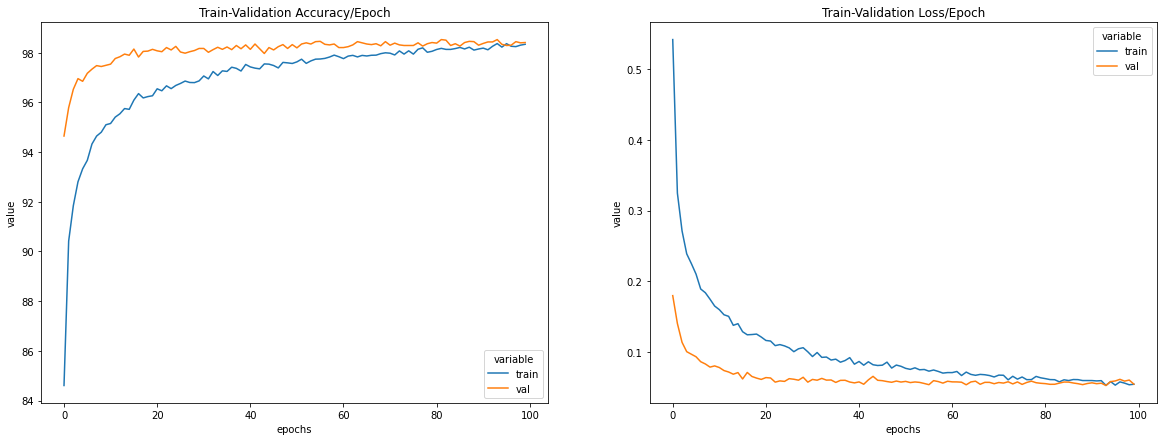

In [82]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Validation Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Validation Loss/Epoch')